In [56]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from feature_engine.outliers import Winsorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

In [62]:
tb = pd.read_csv('../data/train.csv', index_col='id')
tb_test = pd.read_csv('../data/test.csv', index_col='id')
tb_data = tb.sample(n=50000, random_state=16)
tb_s1 = tb.sample(n=50000, random_state=32)
tb_s2 = tb.sample(n=50000, random_state=64)

In [3]:
feature_eng = Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr',
                                                      tail='both')),
                              ('power', PowerTransformer()),
                              ('range', MinMaxScaler())])
feature_eng.get_params()

{'memory': None,
 'steps': [('outliers', Winsorizer(capping_method='iqr', tail='both')),
  ('power', PowerTransformer()),
  ('range', MinMaxScaler())],
 'verbose': False,
 'outliers': Winsorizer(capping_method='iqr', tail='both'),
 'power': PowerTransformer(),
 'range': MinMaxScaler(),
 'outliers__capping_method': 'iqr',
 'outliers__fold': 3,
 'outliers__missing_values': 'raise',
 'outliers__tail': 'both',
 'outliers__variables': None,
 'power__copy': True,
 'power__method': 'yeo-johnson',
 'power__standardize': True,
 'range__clip': False,
 'range__copy': True,
 'range__feature_range': (0, 1)}

In [4]:
tb_data_fe = pd.DataFrame(feature_eng.fit_transform(tb_data.loc[:, :'f99']), columns=tb_data.columns[:100])
tb_s1_fe = pd.DataFrame(feature_eng.fit_transform(tb_s1.loc[:, :'f99']), columns=tb_data.columns[:100])
tb_s2_fe = pd.DataFrame(feature_eng.fit_transform(tb_s2.loc[:, :'f99']), columns=tb_data.columns[:100])

In [5]:
tb_data_Y = tb_data['target']
tb_s1_Y = tb_s1['target']
tb_s2_Y = tb_s2['target']

In [6]:
# feature selection

forest = RandomForestClassifier(n_estimators=200,
                                max_depth=24,
                                min_samples_split=100,
                                min_samples_leaf=50,
                                n_jobs=-1)
forest_fits = []
samples = [tb_data_fe, tb_s1_fe, tb_s2_fe]
ys = [tb_data_Y, tb_s1_Y, tb_s2_Y]

for i in range(len(samples)):
    temp = forest.fit(samples[i], ys[i])
    forest_fits.append(temp.feature_importances_)

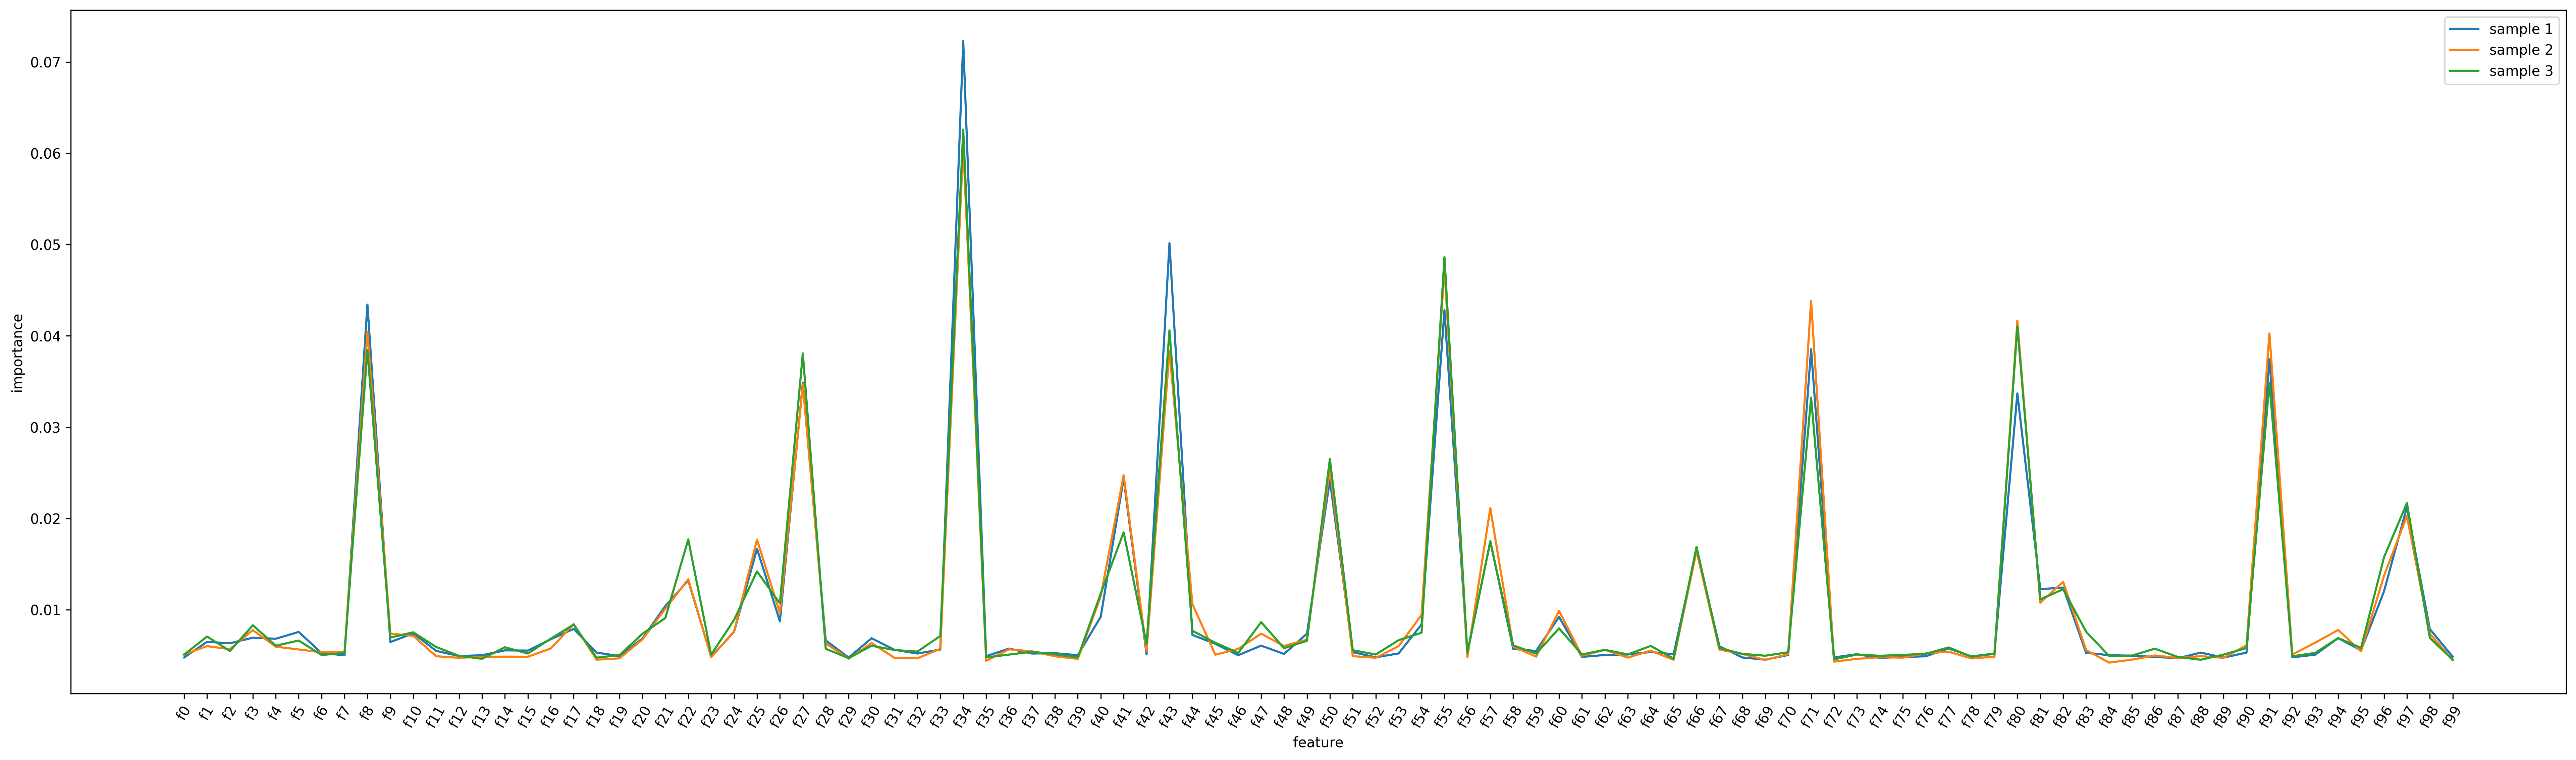

In [7]:
plt.figure(figsize=[32, 9], dpi=300)
sns.lineplot(x=tb_data.columns[:100], y=forest_fits[0], label='sample 1')
sns.lineplot(x=tb_s1.columns[:100], y=forest_fits[1], label='sample 2')
sns.lineplot(x=tb_s2.columns[:100], y=forest_fits[2], label='sample 3')
plt.xticks(rotation=60)
plt.xlabel('feature')
plt.ylabel('importance')
plt.show()

In [14]:
rfecv = RFECV(estimator=forest, step=0.1, cv=6, n_jobs=-1, scoring="accuracy")
rfecv_fits = []

for i in range(len(samples)):
    temp_rfecv = rfecv.fit(samples[i], ys[i])
    rfecv_fits.append(temp_rfecv.cv_results_)

C:\Users\hewar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(
C:\Users\hewar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(
C:\Users\hewar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


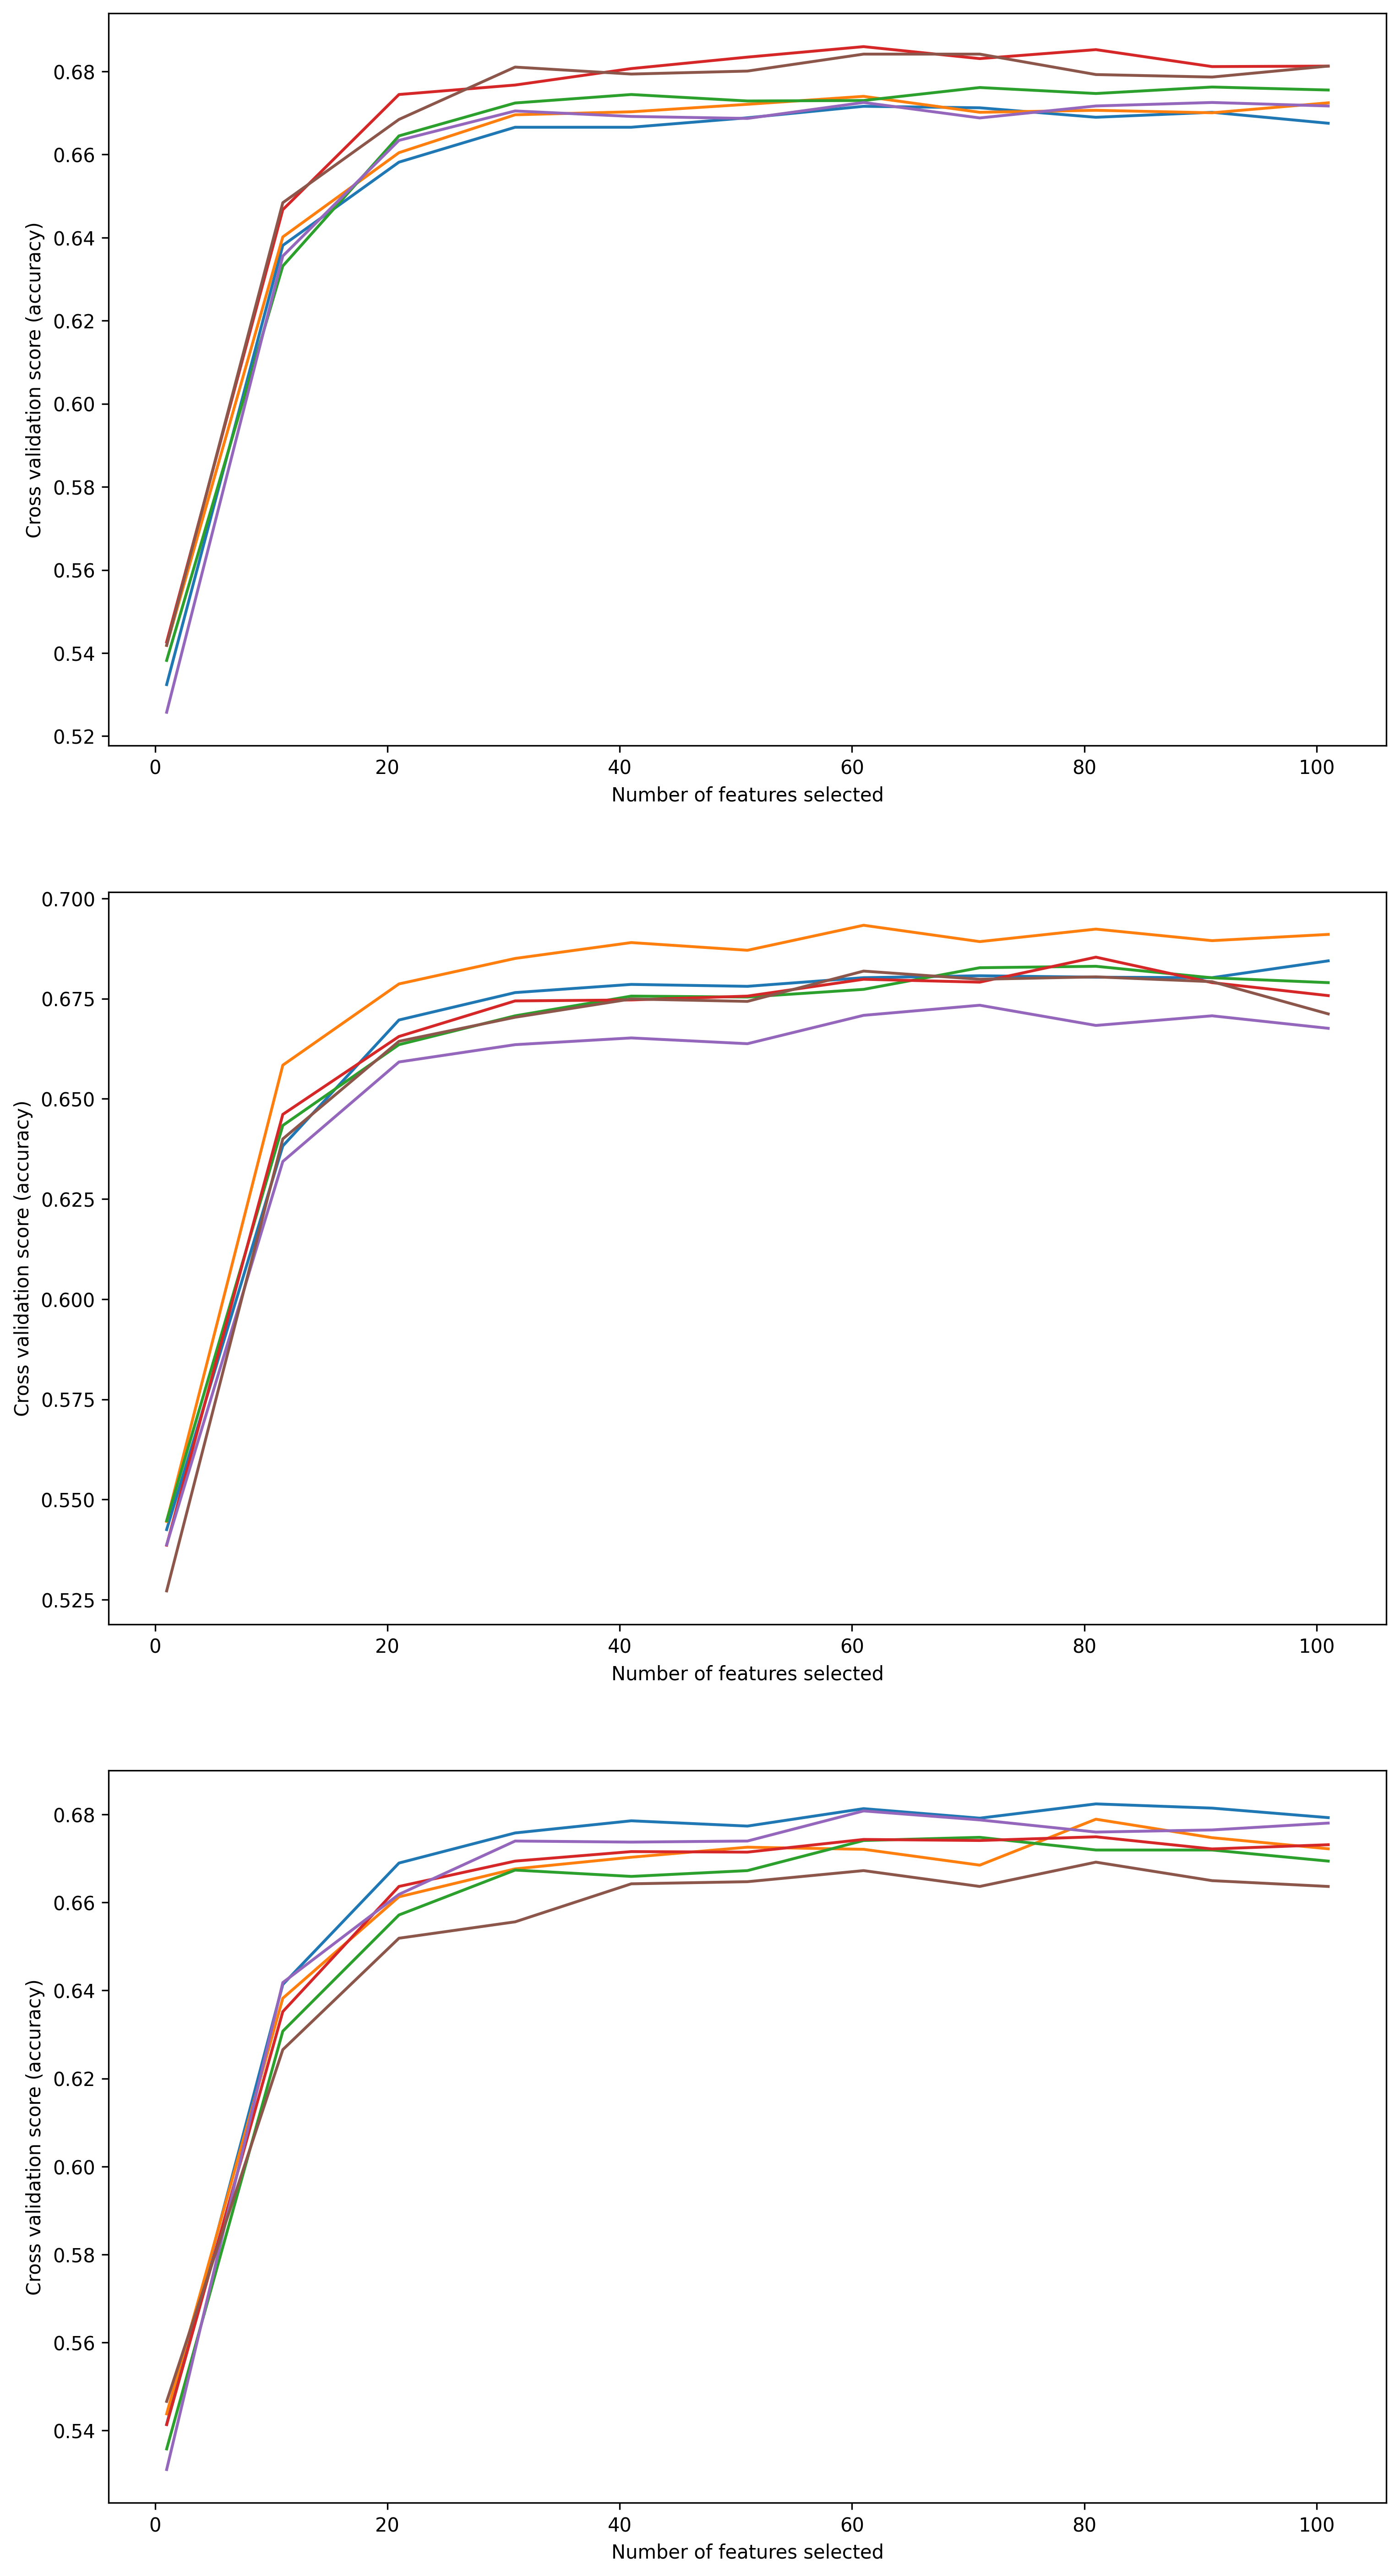

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=[12, 24], dpi=300)

for i in range(3):
    sns.lineplot(x=list(range(1, 110, 10)), y=rfecv_fits[i]['split0_test_score'], ax=axes[i])
    sns.lineplot(x=list(range(1, 110, 10)), y=rfecv_fits[i]['split1_test_score'], ax=axes[i])
    sns.lineplot(x=list(range(1, 110, 10)), y=rfecv_fits[i]['split2_test_score'], ax=axes[i])
    sns.lineplot(x=list(range(1, 110, 10)), y=rfecv_fits[i]['split3_test_score'], ax=axes[i])
    sns.lineplot(x=list(range(1, 110, 10)), y=rfecv_fits[i]['split4_test_score'], ax=axes[i])
    sns.lineplot(x=list(range(1, 110, 10)), y=rfecv_fits[i]['split5_test_score'], ax=axes[i])
    axes[i].set_xlabel("Number of features selected")
    axes[i].set_ylabel("Cross validation score (accuracy)")

plt.show()

In [29]:
print(f'Optimal number of features can use in models: {temp_rfecv.n_features_}')

Optimal number of features can use in models: 80


In [36]:
# update pipeline

top = Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr',
                                              tail='both')),
                      ('power', PowerTransformer()),
                      ('range', MinMaxScaler()),
                      ('select', SelectKBest(score_func=mutual_info_classif, k=80))])
top.get_params()

{'memory': None,
 'steps': [('outliers', Winsorizer(capping_method='iqr', tail='both')),
  ('power', PowerTransformer()),
  ('range', MinMaxScaler()),
  ('select',
   SelectKBest(k=80,
               score_func=<function mutual_info_classif at 0x0000018C3FFF05E0>))],
 'verbose': False,
 'outliers': Winsorizer(capping_method='iqr', tail='both'),
 'power': PowerTransformer(),
 'range': MinMaxScaler(),
 'select': SelectKBest(k=80,
             score_func=<function mutual_info_classif at 0x0000018C3FFF05E0>),
 'outliers__capping_method': 'iqr',
 'outliers__fold': 3,
 'outliers__missing_values': 'raise',
 'outliers__tail': 'both',
 'outliers__variables': None,
 'power__copy': True,
 'power__method': 'yeo-johnson',
 'power__standardize': True,
 'range__clip': False,
 'range__copy': True,
 'range__feature_range': (0, 1),
 'select__k': 80,
 'select__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_classif(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, ran

In [38]:
train_sample = tb.sample(n=100000, random_state=128)
train_sample_Y = train_sample['target']
train_sample_X = top.fit_transform(train_sample.loc[:, :'f99'], train_sample_Y)
train_sample_X

array([[0.37797949, 0.71995193, 0.65570637, ..., 0.35909052, 1.        ,
        0.72545525],
       [0.71392769, 0.35420404, 0.34605308, ..., 0.52201262, 0.7025989 ,
        0.73714339],
       [0.09564474, 0.30701885, 0.4225607 , ..., 0.5461776 , 0.65409077,
        1.        ],
       ...,
       [0.5059293 , 0.37310928, 0.71470805, ..., 0.54468558, 0.65813768,
        0.88466394],
       [0.55780714, 0.79495876, 0.86912185, ..., 0.33049889, 0.6589377 ,
        0.78995559],
       [0.58447494, 0.26459536, 0.53785808, ..., 0.50856626, 0.6439755 ,
        0.7182098 ]])

In [46]:
trainX, testX, trainY, testY = train_test_split(train_sample_X, train_sample_Y, test_size=0.2)
trainX.shape, trainY.shape, testX.shape, testY.shape

((80000, 80), (80000,), (20000, 80), (20000,))

In [43]:
cv = RepeatedKFold(n_splits=6, n_repeats=12)

In [47]:
# K Nearest Neighbors

knn = KNeighborsClassifier(n_neighbors=9, leaf_size=45, n_jobs=-1)

knn_scores = cross_validate(estimator=knn,
                            X=trainX, y=trainY,
                            scoring='accuracy', cv=cv, n_jobs=-1)

In [49]:
np.mean(knn_scores['test_score'])

0.5909000010510987

In [54]:
knn.fit(trainX, trainY)

<Figure size 2400x2400 with 0 Axes>

<Figure size 2400x2400 with 0 Axes>

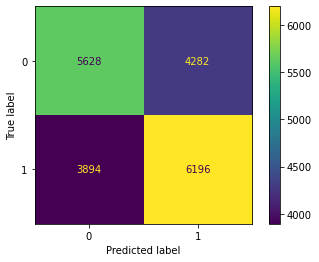

In [55]:
knn_cm = confusion_matrix(testY, knn.predict(testX))

plt.figure(figsize=[8, 8], dpi=300)
knn_cm_disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm, display_labels=knn.classes_)
knn_cm_disp.plot()
plt.show()

<Figure size 2400x2400 with 0 Axes>

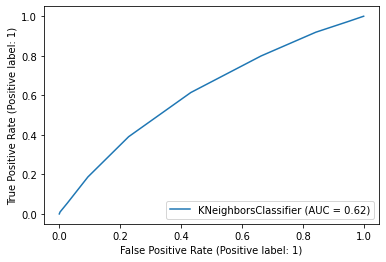

In [57]:
plt.figure(figsize=[8, 8], dpi=300)
RocCurveDisplay.from_estimator(knn, testX, testY)
plt.show()

In [58]:
knn.score(testX, testY)

0.5912

## full training data

In [61]:
tb_full = top.fit_transform(tb.loc[:, :'f99'], tb['target'])
tb_full

array([[0.86227745, 0.6984567 , 0.81127656, ..., 0.45491872, 0.73530681,
        0.92957589],
       [0.86649091, 0.45662587, 0.79720695, ..., 0.53497548, 0.58676955,
        0.70668711],
       [0.84467975, 0.43304908, 0.83458619, ..., 0.47669074, 0.77917513,
        0.85508583],
       ...,
       [0.99141922, 0.29253275, 0.79449724, ..., 0.31149241, 0.73397551,
        0.746663  ],
       [0.93013416, 0.72629659, 0.94462787, ..., 0.60520003, 0.70480882,
        0.6742636 ],
       [0.87812855, 0.68197041, 0.81789706, ..., 0.45310957, 0.68886838,
        0.73537795]])

In [63]:
tb_f_trainX, tb_f_testX, tb_f_trainY, tb_f_testY = train_test_split(tb_full, tb['target'], test_size=0.3)

In [64]:
knn_full = knn.fit(tb_f_trainX, tb_f_trainY)
knn_full.score(tb_f_testX, tb_f_testY)

0.6019222222222222

<Figure size 2400x2400 with 0 Axes>

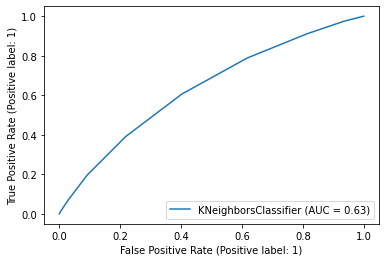

In [65]:
plt.figure(figsize=[8, 8], dpi=300)
RocCurveDisplay.from_estimator(knn_full, tb_f_testX, tb_f_testY)
plt.show()

### submission 01

In [66]:
trans_data = top.transform(tb_test)
trans_data

array([[0.8354811 , 0.84425748, 0.90762651, ..., 0.4440909 , 0.7867716 ,
        0.68700636],
       [0.83701809, 0.29304954, 0.69375135, ..., 0.68175982, 0.68667289,
        0.82702683],
       [0.9979642 , 0.55584032, 0.68191053, ..., 0.63458976, 0.7618954 ,
        0.76260336],
       ...,
       [0.91343771, 0.5674381 , 0.7257823 , ..., 0.02102096, 1.        ,
        0.83088971],
       [1.        , 0.67689124, 0.78345354, ..., 0.24430531, 0.6960673 ,
        0.78498785],
       [0.92569181, 0.585279  , 0.86814269, ..., 0.22375937, 0.71845969,
        0.80751571]])

In [67]:
knn_predictions = knn_full.predict(trans_data)
knn_predictions

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [77]:
temp_knn = pd.DataFrame(data=knn_predictions, index=tb_test.index, columns=['target'])
temp_knn.to_csv('../data/knn_prediction_baseline.csv')

In [ ]:
# Decision Tree

tree = DecisionTreeClassifier(max_depth=18, min_samples_split=150, min_samples_leaf=75)

tree_scores = cross_validate(estimator=tree,
                             X=trainX, y=trainY,
                             scoring='accuracy', cv=cv, n_jobs=-1)